In [1]:
import numpy as np
from robot_navigation import is_segments_intersect, check_polyline
from matplotlib import pyplot as plt

In [2]:
segment_1 = (np.array([6, 5]), np.array([7, 4])) 
segment_2 = (np.array([3, 7]), np.array([7, 7]))


is_segments_intersect(segment_1, segment_2)

False

In [3]:
obstacles = [
    np.array([[2,2], [2,4], [3,3]]),
	np.array([[5,4], [4,6],[6,5],[7,4]])
]

In [4]:
path = [np.array([0, 0]), 
        np.array([2, 0]), 
        np.array([4, 3]), 
        np.array([3, 5]), 
        np.array([7, 7])]

In [7]:
check_polyline(polyline=path, obstacles=obstacles)

segments intersect: (array([5, 4]), array([4, 6])) (array([3, 5]), array([7, 7]))


False

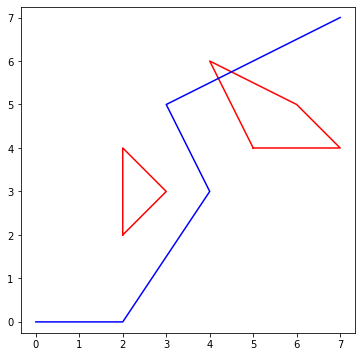

In [8]:
plt.figure(figsize=(6,6))
plt.axis('equal')

for ob in obstacles:
    ob = list(ob)
    ob.append(ob[0])
    x,y = zip(*ob)
    plt.plot(x, y, c='red')
    
x,y = zip(*path)
plt.plot(x,y,'blue')
plt.show()

# solution

In [10]:
import json

with open('robot_data.json', 'r') as f:
    data = json.load(f)
    
data

{'start': [0, 0],
 'finish': [10, 10],
 'obstacles': [[[2, 2], [2, 4], [3, 3]], [[5, 4], [4, 6], [6, 5], [7, 4]]]}

In [64]:
start, finish = np.array(data['start']), np.array(data['finish'])
obstacles = data['obstacles']

first_step = np.array([[0, 0], [1, 1]])
line = np.array([start, finish])

is_segments_intersect(first_step, line)

False

In [65]:
step = 0.1
curr_step = start*step + (1-step) * finish
curr_step

array([9., 9.])

In [69]:
obj = obstacles[1]
obj

[[5, 4], [4, 6], [6, 5], [7, 4]]

In [70]:
for vec1, vec2 in zip(obj, np.vstack([obj[1:], obj[0]])):
    line1 = np.array((vec1, vec2))
    print(line1)
    print(is_segments_intersect(line1, (start, curr_step)))

[[5 4]
 [4 6]]
True
[[4 6]
 [6 5]]
True
[[6 5]
 [7 4]]
False
[[7 4]
 [5 4]]
False


In [61]:
(start, curr_step)

(array([0, 0]), array([9., 9.]))

In [62]:
line1

array([[3, 3],
       [2, 2]])